# Plate Tectonic Stats

Basic kinematic information on:

1. MOR length
2. Spreading rates
3. Crustal production
4. Subduction convergence rates
5. Age of subducting crust
6. "World Uncertainty"

This workflow is __multithreaded__ and should execute very quickly!

In [1]:
from multiprocessing import Pool, cpu_count
from joblib import Parallel, delayed
import numpy as np
import gplately.pygplates as pygplates
import ptt
import gplately
from gplately import tools
from slabdip import SlabDipper
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader as shpreader
import netCDF4
import warnings
from scipy import ndimage
from scipy.interpolate import RegularGridInterpolator
import os, glob
import pandas as pd
%matplotlib inline
# plt.style.use('ggplot')

# common variables
extent_globe = [-180, 180, -90, 90]
earth_radius = 6371.0e3
earth_surface_area = 4.0*np.pi*earth_radius**2
tessellation_threshold_radians = np.radians(0.01)

# output grid resolution - should be identical to input grid resolution!
spacingX, spacingY = 0.2, 0.2
resX, resY = int(360./0.2 + 1), int(180./0.2 + 1)
lon_grid = np.arange(extent_globe[0], extent_globe[1]+spacingX, spacingX)
lat_grid = np.arange(extent_globe[2], extent_globe[3]+spacingY, spacingY)
lonq, latq = np.meshgrid(lon_grid,lat_grid)

# reconstruction time steps and spacing
min_time = 0
max_time = 1000
timestep_size = 1

# reversed (start at max_time, end at min_time)
reconstruction_times = np.arange(min_time, max_time+timestep_size, timestep_size)[::-1]

save_output_netcdf = False # !! important
save_output_snapshots = False

In [2]:
cell_area = tools.lat_area_function(lat_grid, lat_grid+spacingY, lon_grid.size)
cell_area = np.tile(cell_area.reshape(-1,1), lon_grid.size)

A function to define paths to grids for use in parallel.

In [3]:
# Change `folder_name`: a string to name a new sub-folder for a new set of Notebook 6 outputs; 
# useful for keeping track of reruns
folder_name = "Muller22_Sep17"

# Don't change this: directory to input files
output_directory = "./Outputs/{}/Notebook06/".format(folder_name)
os.makedirs(output_directory, exist_ok=True)
os.makedirs(output_directory+"/figures", exist_ok=True)
os.makedirs(output_directory+"/csv", exist_ok=True)

In [4]:
grid_directory = "./Muller2022_InputGrids/".format()
def defineGridFiles():
    
    #grid_directory = input_directory+"SRGrids/"
    spreadrate_filename = grid_directory+"SpreadingRate/Muller2022_SPREADING_RATE_grid_{:.2f}Ma.nc"
    agegrid_filename = grid_directory+"SeafloorAge/Muller2022_SEAFLOOR_AGE_grid_{:.2f}Ma.nc"
    
    return agegrid_filename, spreadrate_filename

In [5]:
# Use GPlately's DataServer to get a rotation model, topology features and static polygons
gdownload = gplately.download.DataServer("Muller2022", verbose=True)
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

model = gplately.PlateReconstruction([f for f in rotation_model.filenames if "1000_0_rotfile_Merdith_et_al_optimised.rot" in f][0], topology_features, static_polygons)


Checking whether the requested files need to be updated...
Requested files are up-to-date!


In [6]:
[f for f in rotation_model.filenames if "1000_0_rotfile_Merdith_et_al_optimised.rot" in f][0]

'/Users/lila0720/Library/Caches/gplately/Muller2022.unzip/Muller_etal_2022_SE_1Ga_Opt_PlateMotionModel_v1.2.2/optimisation/1000_0_rotfile_Merdith_et_al_optimised.rot'

In [7]:

# For this notebook, we only need to define a set of passive margins as COBs.
COBs = grid_directory+"ContinentalMasks/passive_margin_features.gpmlz"
continents = grid_directory+"ContinentalMasks/continent_contour_features.gpmlz"
# This initial time can be any time - this is just to have a placeholder time to resolve topologies and continents to. 
time = 1000
gplot = gplately.plot.PlotTopologies(model, time=time, COBs=COBs, continents=continents)


Process plate boundary stats in parallel:

In [8]:
def plate_tectonic_stats(time, model, tessellation_threshold_radians):
    """All in SI units"""
    
    # Define paths to grids
    agegrid_filename, spreadrate_filename = defineGridFiles()

    ##################### Ridge spreading data ################################
    ridge_data = model.tessellate_mid_ocean_ridges(
        time,
        tessellation_threshold_radians,
        anchor_plate_id=0)
    headers = ['longitude', 'latitude', 'spreading_velocity_magnitude', 'arc_segment_length']
    ridge_df = pd.DataFrame(list(ridge_data), columns = headers)

    ridge_df.loc[ridge_df['spreading_velocity_magnitude'] >= 0]
    ridge_lon = ridge_df.longitude.to_numpy()
    ridge_lat = ridge_df.latitude.to_numpy()
    ridge_vel = ridge_df.spreading_velocity_magnitude.to_numpy()*1e-2 # m/yr
    ridge_len = np.radians(ridge_df.arc_segment_length.to_numpy()) * 1e3 * pygplates.Earth.mean_radius_in_kms # m

    ridge_len_sum = np.sum(ridge_len)
    ridge_vel_mean, ridge_vel_std = np.mean(ridge_vel), np.std(ridge_vel)
        
    # crustal surface area produced over 1 yr
    ridge_surface_area = np.sum(ridge_vel * ridge_len)
    
    
    ###################### Subduction convergence data ########################
    # Initialise SlabDipper object, allocate it a spreading rate grid and an age grid
    dipper = SlabDipper()
    dipper._model = model
    dipper.set_age_grid_filename(agegrid_filename)
    dipper.set_spreading_rate_grid_filename(spreadrate_filename)

    subduction_df = dipper.tessellate_slab_dip(time, tessellation_threshold_radians)

    subduction_lon     = subduction_df.lon
    subduction_lat     = subduction_df.lat
    subduction_length  = subduction_df.length # m
    subd_len_sum = np.sum(subduction_length) 
        
    subduction_convergence = subduction_df.vel # m/yr
    subd_vel_mean, subd_vel_std = np.mean(subduction_convergence), np.std(subduction_convergence)
    
    # area subducted by trenches over 1 yr
    subd_surface_area = np.sum(subduction_convergence * subduction_length) # m^2/yr
    
    
    # sample age grid
    age_interp = subduction_df.slab_age
    thickness = subduction_df.slab_thickness
    age_mean, age_std = np.mean(age_interp), np.std(age_interp)
    

    # Accretion: Clift and Vannucchi (2004)
    accretion = (-0.4/0.068)*subduction_convergence + 0.4
    accretion_mean, accretion_std = np.mean(accretion), np.std(accretion)
    
    slab_dip = subduction_df.slab_dip
    slab_dip_mean, slab_dip_std = np.median(slab_dip), np.std(slab_dip)
    
    del subduction_df, ridge_df # clean up
    
    return(ridge_len_sum, ridge_vel_mean, ridge_vel_std, ridge_surface_area, \
           subd_len_sum,  subd_vel_mean,   subd_vel_std, subd_surface_area, \
           age_mean, age_std, accretion_mean, accretion_std, slab_dip_mean, slab_dip_std, \
          subduction_lon.to_numpy(), subduction_lat.to_numpy(), subduction_length.to_numpy())

In [9]:
plate_tectonic_stats(1000, model, tessellation_threshold_radians)

(np.float64(16707118.72286406),
 np.float64(0.0395571367927262),
 np.float64(0.01908471372699067),
 np.float64(660748.1168334547),
 np.float64(67254681.8655305),
 np.float64(0.012826551188285332),
 np.float64(0.02067796961456658),
 np.float64(862817.9465968714),
 np.float64(94.67074649889983),
 np.float64(71.47957612193072),
 np.float64(0.3245496988924393),
 np.float64(0.12163511537980341),
 np.float64(27.56221044444369),
 np.float64(8.662146282402759),
 array([ 171.37726186,  171.36909858,  171.36093342, ..., -159.54541822,
        -159.55834626, -159.57127497]),
 array([40.12611675, 40.13392913, 40.14174093, ..., 40.38008785,
        40.38182067, 40.38355204]),
 array([1111.89368311, 1111.89369527, 1111.89371148, ..., 1111.87029371,
        1111.87029777, 1111.87011538]))

In [10]:
ptt_stats = Parallel(n_jobs=-2,
                     verbose=1) \
(delayed(plate_tectonic_stats) \
 (time, model, tessellation_threshold_radians) for time in reconstruction_times)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done  32 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-2)]: Done 182 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-2)]: Done 432 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-2)]: Done 782 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-2)]: Done 1001 out of 1001 | elapsed: 12.7min finished


In [11]:
stats = np.zeros((14,reconstruction_times.size))
subd_lons = np.zeros((1,reconstruction_times.size))
subd_lats = np.zeros((1,reconstruction_times.size))

for t, reconstruction_time in enumerate(reconstruction_times):
    stats[:,t] = np.array(ptt_stats[t][:-3]).T
    

## Calculate total global passive margin lengths through time

In [12]:
def get_passive_margin_tot_len(time, gplot):
    total_passive_margin_length_kms = 0
    gplot.time = time
    for margin in gplot.COBs:   
        clat, clon = margin.get_reconstructed_geometry().get_centroid().to_lat_lon()
        earth_radius = tools.geocentric_radius(clat) / 1e3
        total_passive_margin_length_kms += margin.get_reconstructed_geometry().get_arc_length()*earth_radius
    return total_passive_margin_length_kms

In [13]:
# Use ThreadingBackend - this is more compatible with purely pyGPlates routines
passive_margin_lengths = Parallel(n_jobs=-2, backend='threading', verbose=1) \
(delayed(get_passive_margin_tot_len) \
 (reconstruction_time, gplot
 ) for i, reconstruction_time in enumerate(reconstruction_times))

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done  32 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-2)]: Done 182 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-2)]: Done 432 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-2)]: Done 782 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-2)]: Done 1001 out of 1001 | elapsed:  4.3min finished


## Rift lengths through time

In [14]:
rift_degassing_pd = pd.read_excel(
    "./utils/rift_degassing_2023dec01_rev2.xlsx",
      usecols=["Unnamed: 0", "Unnamed: 1"], header=0).drop([0, 1, 2, 3, 4],).rename(
    columns={'Unnamed: 0': 'time', 'Unnamed: 1': 'raw_rift_length'}
).reset_index(drop=True)

rift_times = rift_degassing_pd['time'].to_numpy()
raw_rift_length = rift_degassing_pd['raw_rift_length'].to_numpy()

### Rift multiplier (Merdith et al., *in review*)

The Neoproterozoic and Early Palaeozoic database predominantly identifies rifts that form during continental breakup and/or terrane detachment and migration. The database of the review paper's Ref. 33 contains these rifts, and also rifts formed in convergent settings, such as back-arc basins. This is likely a function of preservation bias. To counteract this issue, we calculated the fraction of rifts formed in convergent settings, which for the period 450–0 Ma is 0.44 (i.e. on average 44% of total rift length in the database (33) formed in convergent settings and is unaccounted for in the estimate of ref(34)). Assuming that this proportion is constant back to 600 Ma, we applied a rift length multiplier of:

$1/0.56 \approx 1.79$

to all rift lengths earlier than 450Ma. 

In [15]:
multiplier_rift_length = []
for t, length in enumerate(raw_rift_length):
    if rift_times[t] > 450:
        new_length = length / 0.56
    else:
        new_length = length
    multiplier_rift_length.append(new_length)
    
# Apply a 20Myr window median filter to the multiplier rift lengths:
#from scipy.signal import savgol_filter
import scipy.ndimage as sn
filtered_multiplier_rift_lengths = sn.median_filter(multiplier_rift_length, size=20)
filtered_raw_rift_lengths = sn.median_filter(raw_rift_length.astype(float), size=20)

In [16]:
raw_rift_length.astype(float)

array([8160.        , 8540.        , 8540.        , ..., 2350.65995887,
       2350.65995887, 2350.65995887])

## Create some plots

In [17]:
import scipy.ndimage as sn
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

### Continental arc lengths and carbonate platform-intersecting trench lengths are imported from Notebook 4.

In [18]:
cont_arc_len_pd = pd.read_csv('./Outputs/{}/Notebook04/csv/continental_arc_length.csv'.format(folder_name), index_col=0, header=[0])

carb_plat_len_pd = pd.read_csv('./Outputs/{}/Notebook04/csv/carbonate_platform_length.csv'.format(folder_name), index_col=0, header=[0])

min_cont_arc_length = cont_arc_len_pd['min_continental_arc_length'].to_numpy()
mean_cont_arc_length = cont_arc_len_pd['mean_continental_arc_length'].to_numpy()
max_cont_arc_length = cont_arc_len_pd['max_continental_arc_length'].to_numpy()
min_carb_plat_int_length = carb_plat_len_pd['min_carbonate_platform_length'].to_numpy()
mean_carb_plat_int_length = carb_plat_len_pd['mean_carbonate_platform_length'].to_numpy()
max_carb_plat_int_length = carb_plat_len_pd['max_carbonate_platform_length'].to_numpy()

### Scale continental arc lengths pre-460Ma and use carbonate platform lengths from 410-0Ma.

In [19]:
# We consider three different percentages of carbonate platform degassing rates. 
percentages = [0.15, 0.25, 0.35]
d_tols = [250., 350., 450.]

time_window = 10 # Myr

# Need to use a separate time array because the main reconstruction time array is reversed.
arc_times = np.arange(min_time, max_time+timestep_size, timestep_size)

scaled_arc_length = np.zeros((len(arc_times), len(d_tols)))

for j, percentage in enumerate(percentages):
    
    for i, t in enumerate(arc_times):
        # Scale all degassing for times earlier than 460Ma.
        if t > 460:
            scaled_arc_length[i,0] = percentage * min_cont_arc_length[t]
            scaled_arc_length[i,1] = percentage * mean_cont_arc_length[t]
            scaled_arc_length[i,2] = percentage * max_cont_arc_length[t]
        
        else:
            
            scaled_arc_length[i,0] = min_carb_plat_int_length[t]
            scaled_arc_length[i,1] = mean_carb_plat_int_length[t]
            scaled_arc_length[i,2] = max_carb_plat_int_length[t]
    
    data_out = np.column_stack((

        scaled_arc_length[:,0],
        scaled_arc_length[:,1],
        scaled_arc_length[:,2],
    ))

    # These values are in Mt/yr
    headers = ['min_combined_continent_carbonate_platform_length', 
               'mean_combined_continent_carbonate_platform_length',
               'max_combined_continent_carbonate_platform_length' ]

    carbon_subducted_df = pd.DataFrame(list(data_out), columns = headers, index=np.arange(min_time,max_time+1,1)) 
    carbon_subducted_df.to_csv(
        output_directory+"/csv/combined_carbonate_platform_len_{}percent.csv".format(percentage*100)
    )
    

### The 0.25 percentage dataframe is what is saved to the Notebook 6 csv

In [20]:
percentage = 0.25

len_pd = pd.read_csv(
    output_directory+"/csv/combined_carbonate_platform_len_{}percent.csv".format(percentage*100),
    index_col=0
)

headers = ['min_combined_continent_carbonate_platform_length', 
           'mean_combined_continent_carbonate_platform_length',
           'max_combined_continent_carbonate_platform_length' ]

min_scaled_len = np.ravel(len_pd[headers[0]].to_numpy())
mean_scaled_len = np.ravel(len_pd[headers[1]].to_numpy())
max_scaled_len = np.ravel(len_pd[headers[2]].to_numpy())


In [21]:
time_window = 10 #Myr

# unpack stats
ridge_len_sum      = sn.median_filter(stats[0] * 1e-3, size=time_window) # m to km
ridge_vel_mean     = sn.median_filter(stats[1] * 100, size=time_window)  # m/yr to cm/yr
ridge_vel_std      = sn.median_filter(stats[2] * 100, size=time_window)  # m/yr to cm/yr
ridge_surface_area = sn.median_filter(stats[3] * 1e-6, size=time_window) # m^2/a to km^2/a
subd_len_sum       = sn.median_filter(stats[4] * 1e-3, size=time_window) # m to km
subd_vel_mean      = sn.median_filter(stats[5] * 100, size=time_window)  # m/yr to cm/yr
subd_vel_std       = sn.median_filter(stats[6] * 100, size=time_window)  # m/yr to cm/yr
subd_surface_area  = sn.median_filter(stats[7] * 1e-6, size=time_window) # m^2 /a to km^2/a
age_mean           = sn.median_filter(stats[8], size=time_window)
age_std            = sn.median_filter(stats[9], size=time_window)
accretion_mean     = sn.median_filter(stats[10], size=time_window)
accretion_std      = sn.median_filter(stats[11], size=time_window)
slab_dip_mean      = sn.median_filter(stats[12], size=time_window)
slab_dip_std       = sn.median_filter(stats[13], size=time_window)
passive_margin_lengths_global = sn.median_filter(passive_margin_lengths, size=time_window)


In [22]:
# save xy data
data_out = np.column_stack((
            ridge_len_sum,
            ridge_vel_mean,
            ridge_vel_std,
            ridge_surface_area,
            subd_len_sum,
            subd_vel_mean,
            subd_vel_std,
            subd_surface_area,
            age_mean,
            age_std,
            accretion_mean*100,
            accretion_std*100,
            slab_dip_mean,
            slab_dip_std,
            passive_margin_lengths_global,
            min_cont_arc_length,
            mean_cont_arc_length,
            max_cont_arc_length,
            min_carb_plat_int_length,
            mean_carb_plat_int_length,
            max_carb_plat_int_length,
            min_scaled_len,
            mean_scaled_len,
            max_scaled_len
            ))

headers = ['ridge_length', 
           'ridge_vel_mean', 
           'ridge_vel_std', 
           'ridge_surface_area', 
           'subduction_length', 
           'subduction_vel_mean', 
           'subduction_vel_std', 
           'subduction_surface_area', 
           'age_mean', 
           'age_std', 
           'accretion_mean', 
           'accretion_std', 
           'slab_dip_mean', 
           'slab_dip_std',
           'passive_margin_length',
           'min_continental_arc_length',
           'mean_continental_arc_length',
           'max_continental_arc_length',
           'min_carb_plat_continental_arc_length',
           'mean_carb_plat_continental_arc_length',
           'max_carb_plat_continental_arc_length',
           'min_combined_arc_length',
           'mean_combined_arc_length',
           'max_combined_arc_length'
]

plate_tectonic_stats = pd.DataFrame(list(data_out), columns=headers, index=reconstruction_times)
plate_tectonic_stats.to_csv(output_directory+'/csv/06_plate_tectonic_stats.csv',  index_label='age')

Reread the csv and plot using the dataframe

In [23]:
ptt_pd = pd.read_csv(output_directory+'/csv/06_plate_tectonic_stats.csv', index_col=0)
ptt_pd = ptt_pd.reindex(index=reconstruction_times)

ridge_len_sum = ptt_pd['ridge_length'].to_numpy()
ridge_vel_mean = ptt_pd['ridge_vel_mean'].to_numpy()
ridge_vel_std = ptt_pd['ridge_vel_std'].to_numpy()

ridge_surface_area = ptt_pd['ridge_surface_area'].to_numpy()
subd_len_sum = ptt_pd['subduction_length'].to_numpy()
subd_vel_mean = ptt_pd['subduction_vel_mean'].to_numpy()
subd_vel_std = ptt_pd['subduction_vel_std'].to_numpy()

subd_surface_area = ptt_pd['subduction_surface_area'].to_numpy()
age_mean = ptt_pd['age_mean'].to_numpy()
age_std = ptt_pd['age_std'].to_numpy()
accretion_mean = ptt_pd['accretion_mean'].to_numpy()
accretion_std = ptt_pd['accretion_std'].to_numpy()
slab_dip_mean = ptt_pd['slab_dip_mean'].to_numpy()
slab_dip_std = ptt_pd['slab_dip_std'].to_numpy()

passive_margin_lengths_global = ptt_pd['passive_margin_length'].to_numpy()
min_cont_arc_length = ptt_pd['min_continental_arc_length'].to_numpy()
mean_cont_arc_length = ptt_pd['mean_continental_arc_length'].to_numpy()
max_cont_arc_length = ptt_pd['max_continental_arc_length'].to_numpy()

min_carb_plat_int_length = ptt_pd['min_carb_plat_continental_arc_length'].to_numpy()
mean_carb_plat_int_length = ptt_pd['mean_carb_plat_continental_arc_length'].to_numpy()
max_carb_plat_int_length = ptt_pd['max_carb_plat_continental_arc_length'].to_numpy()

In [24]:
crustal_production_destruction_pd = pd.read_csv(
    "./utils/crustal_production_destruction.csv",
    index_col=0
)
ridge_surface_area = crustal_production_destruction_pd['ridge_surface_area'].to_numpy()
subd_surface_area = crustal_production_destruction_pd['ridge_surface_area'].to_numpy()

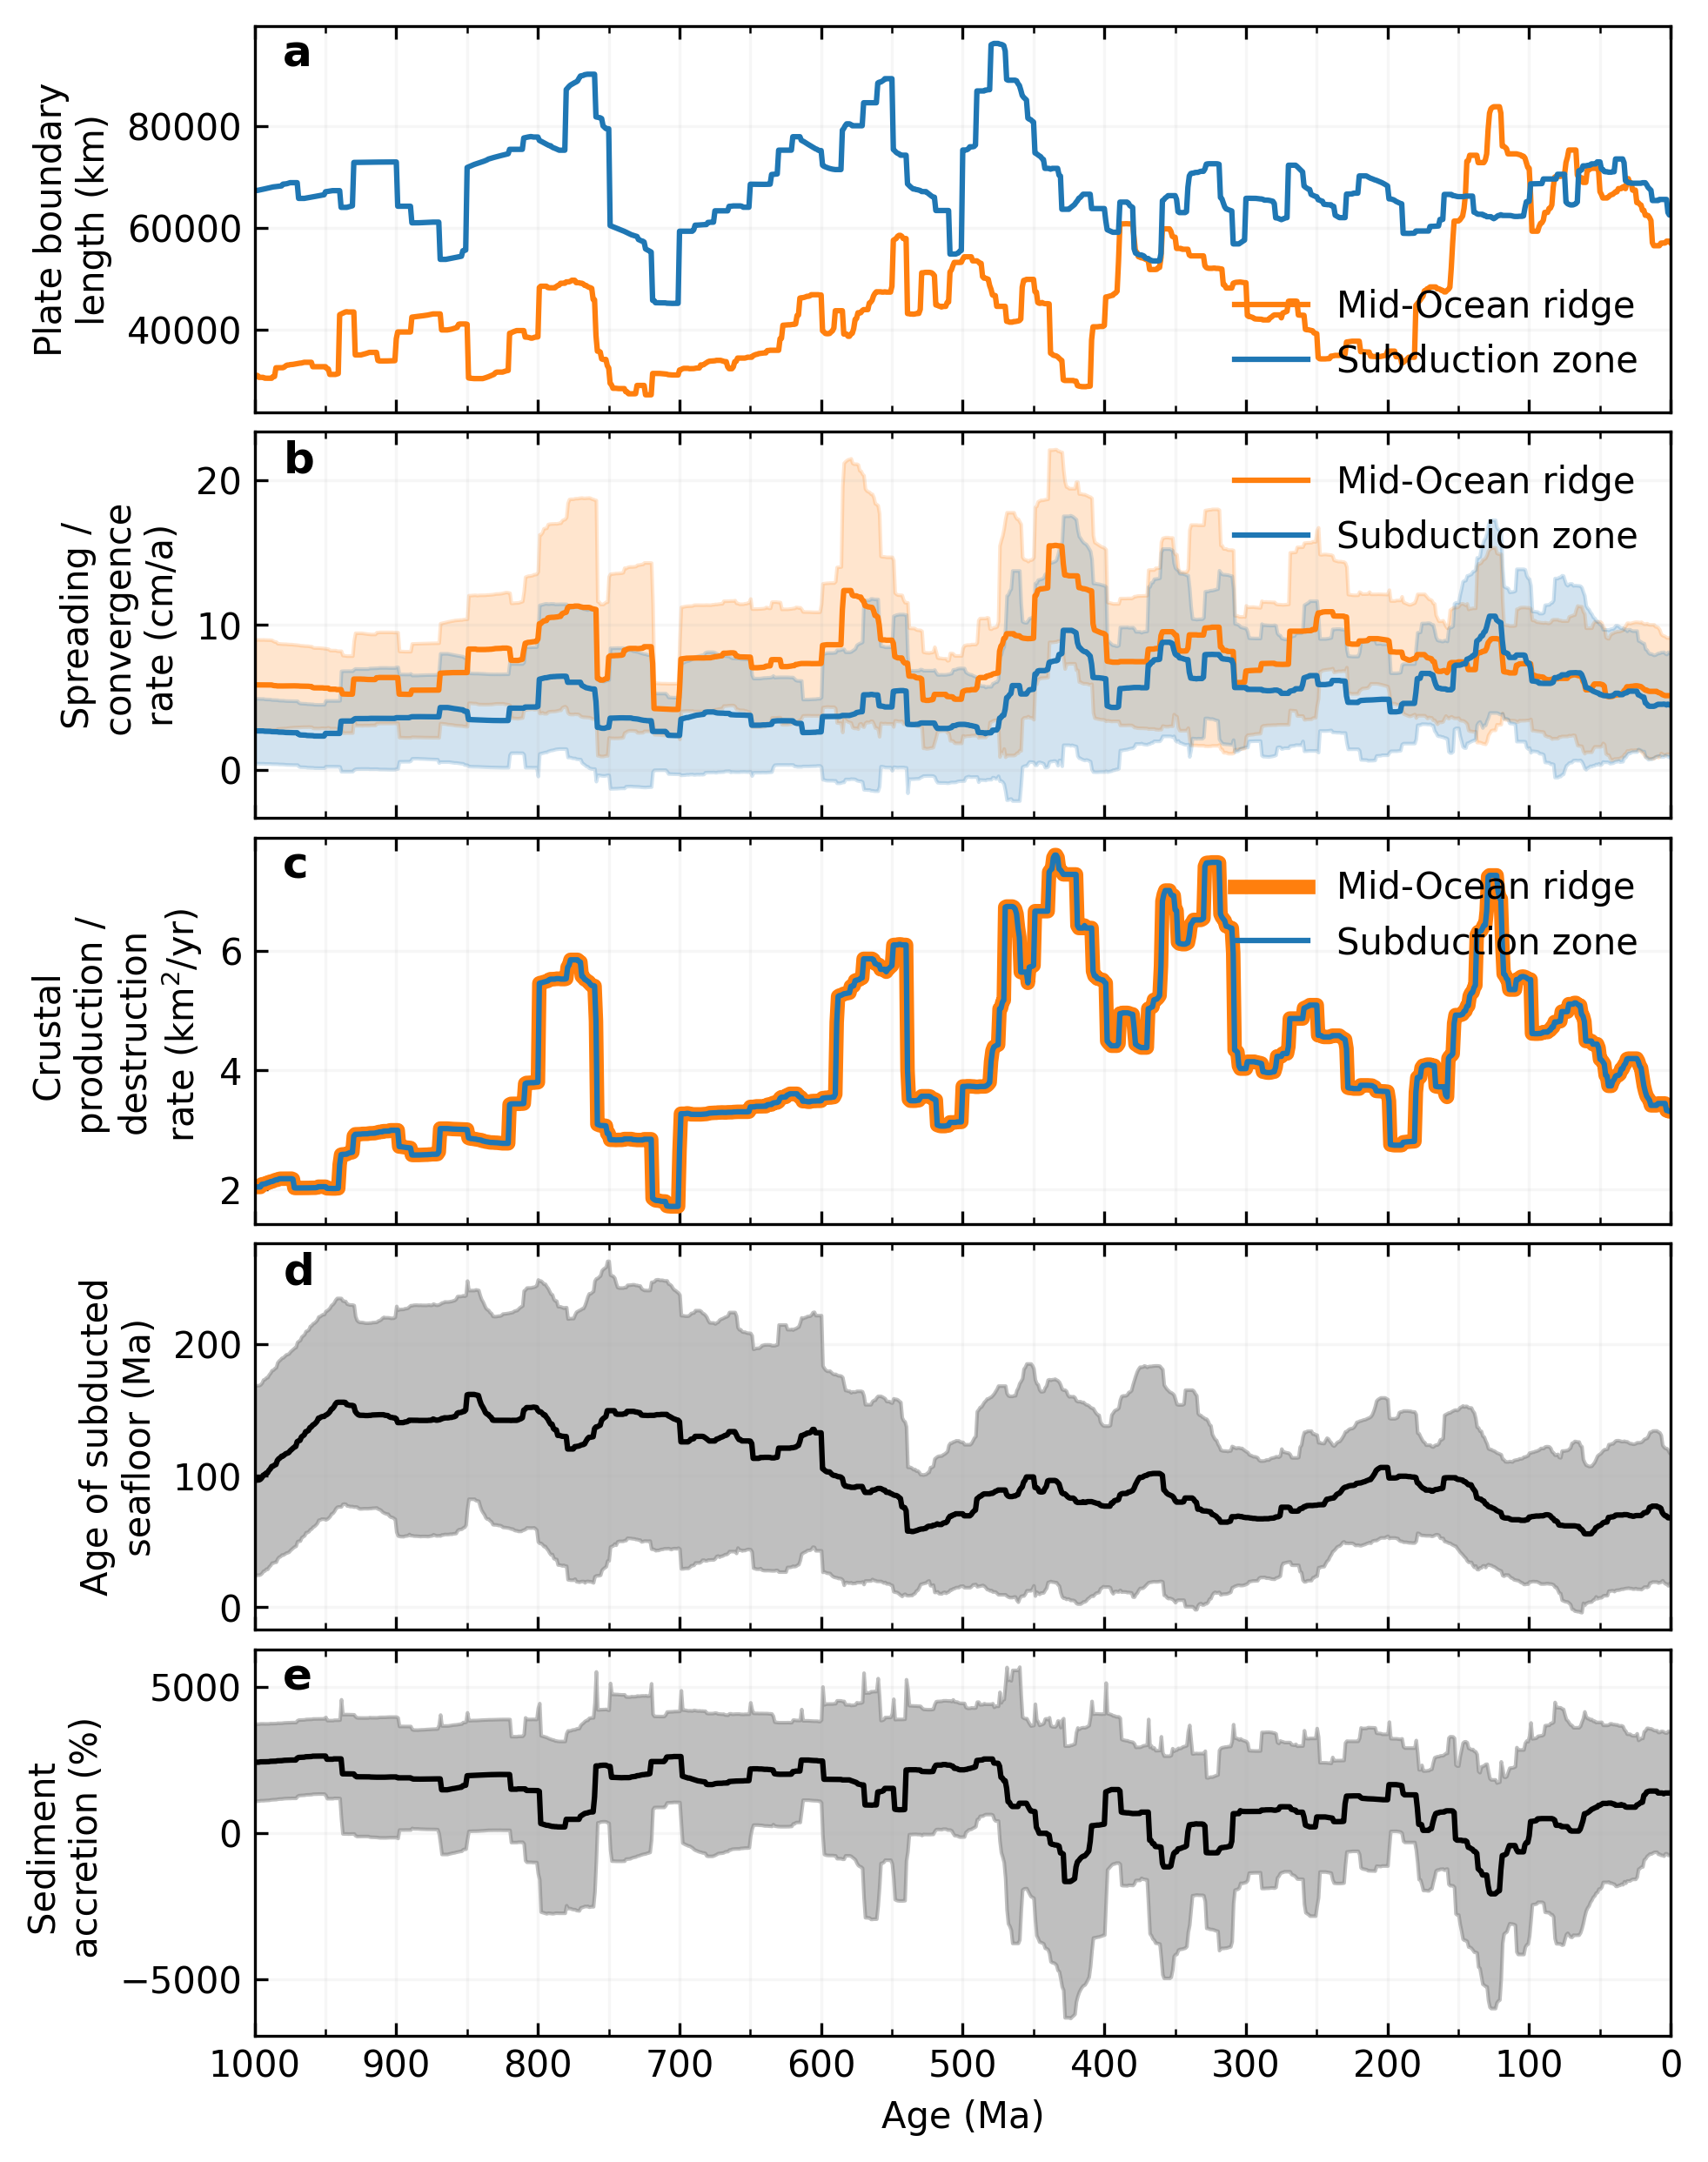

In [25]:
fig, axes = plt.subplots(5, 1, figsize=(7,10), dpi=300)
fig.subplots_adjust(hspace=0.05)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
n_axes = len(axes)

axes[0].set_ylabel('Plate boundary\nlength (km)')
ln1, = axes[0].plot(reconstruction_times, ridge_len_sum, c='C1',  label="Mid-Ocean ridge")
ln2, = axes[0].plot(reconstruction_times, subd_len_sum, c='C0', label='Subduction zone')
axes[0].legend(loc='lower right', frameon=False)

axes[1].set_ylabel('Spreading /\n convergence\nrate (cm/a)')
axes[1].fill_between(reconstruction_times, ridge_vel_mean-ridge_vel_std, ridge_vel_mean+ridge_vel_std,
                     edgecolor='k', color='C1', alpha=0.2)
axes[1].fill_between(reconstruction_times, subd_vel_mean-subd_vel_std, subd_vel_mean+subd_vel_std,
                     edgecolor='k', color='C0', alpha=0.2)
axes[1].plot(reconstruction_times, ridge_vel_mean, c='C1', label="Mid-Ocean ridge")
axes[1].plot(reconstruction_times, subd_vel_mean, c='C0', label="Subduction zone")
axes[1].legend(loc='upper right', frameon=False)

axes[2].set_ylabel('Crustal \n production /\ndestruction\n rate (km$^2$/yr)')
axes[2].plot(reconstruction_times, ridge_surface_area, linewidth=4, c='C1', label="Mid-Ocean ridge")
axes[2].plot(reconstruction_times, subd_surface_area, c='C0', label='Subduction zone')
axes[2].legend(loc='upper right', frameon=False)

axes[3].set_ylabel('Age of subducted\nseafloor (Ma)')
axes[3].fill_between(reconstruction_times, age_mean-age_std, age_mean+age_std, color='0.5', alpha=0.5)
axes[3].plot(reconstruction_times, age_mean, c='k')

axes[4].set_ylabel('Sediment \n accretion (%)')
axes[4].fill_between(reconstruction_times, (accretion_mean-accretion_std)*100, (accretion_mean+accretion_std)*100,
                    color='0.5', alpha=0.5)
axes[4].plot(reconstruction_times, accretion_mean*100, c='k')
plt.grid(which='both', alpha=0.1)
for i, ax in enumerate(axes):
    ax.set_xlim(max_time, 0)
    ax.set_xticks(np.arange(1000,-1,-100))
    if i < n_axes-1:
        ax.grid(alpha=0.1, which='both')
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.set_xticklabels([])
        ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)
        ax.xaxis.set_minor_locator(MultipleLocator(50))
    else:
        #ax.set_xticklabels(axes[6].get_xticks()[::2], rotation = 45)
        ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)
        ax.xaxis.set_minor_locator(MultipleLocator(50))
        ax.set_xticklabels(axes[n_axes-1].get_xticks())
        ax.set_xlabel("Age (Ma)")
        
img_id = ["a","b","c","d","e",]
for i, ax in enumerate(axes):
    
    ax.annotate('{}'.format(img_id[i]), xy=(0.02, 0.98), xycoords='axes fraction', fontsize=12, fontweight="bold",
                horizontalalignment='left', verticalalignment='top')


plt.show()
fig.savefig(output_directory+"/figures/plate_tectonic_stats_pt1.pdf", dpi=300, bbox_inches='tight')
fig.savefig(output_directory+"/figures/plate_tectonic_stats_pt1.svg", dpi=300, bbox_inches='tight')
fig.savefig(output_directory+"/figures/plate_tectonic_stats_pt1.png", dpi=300, bbox_inches='tight')


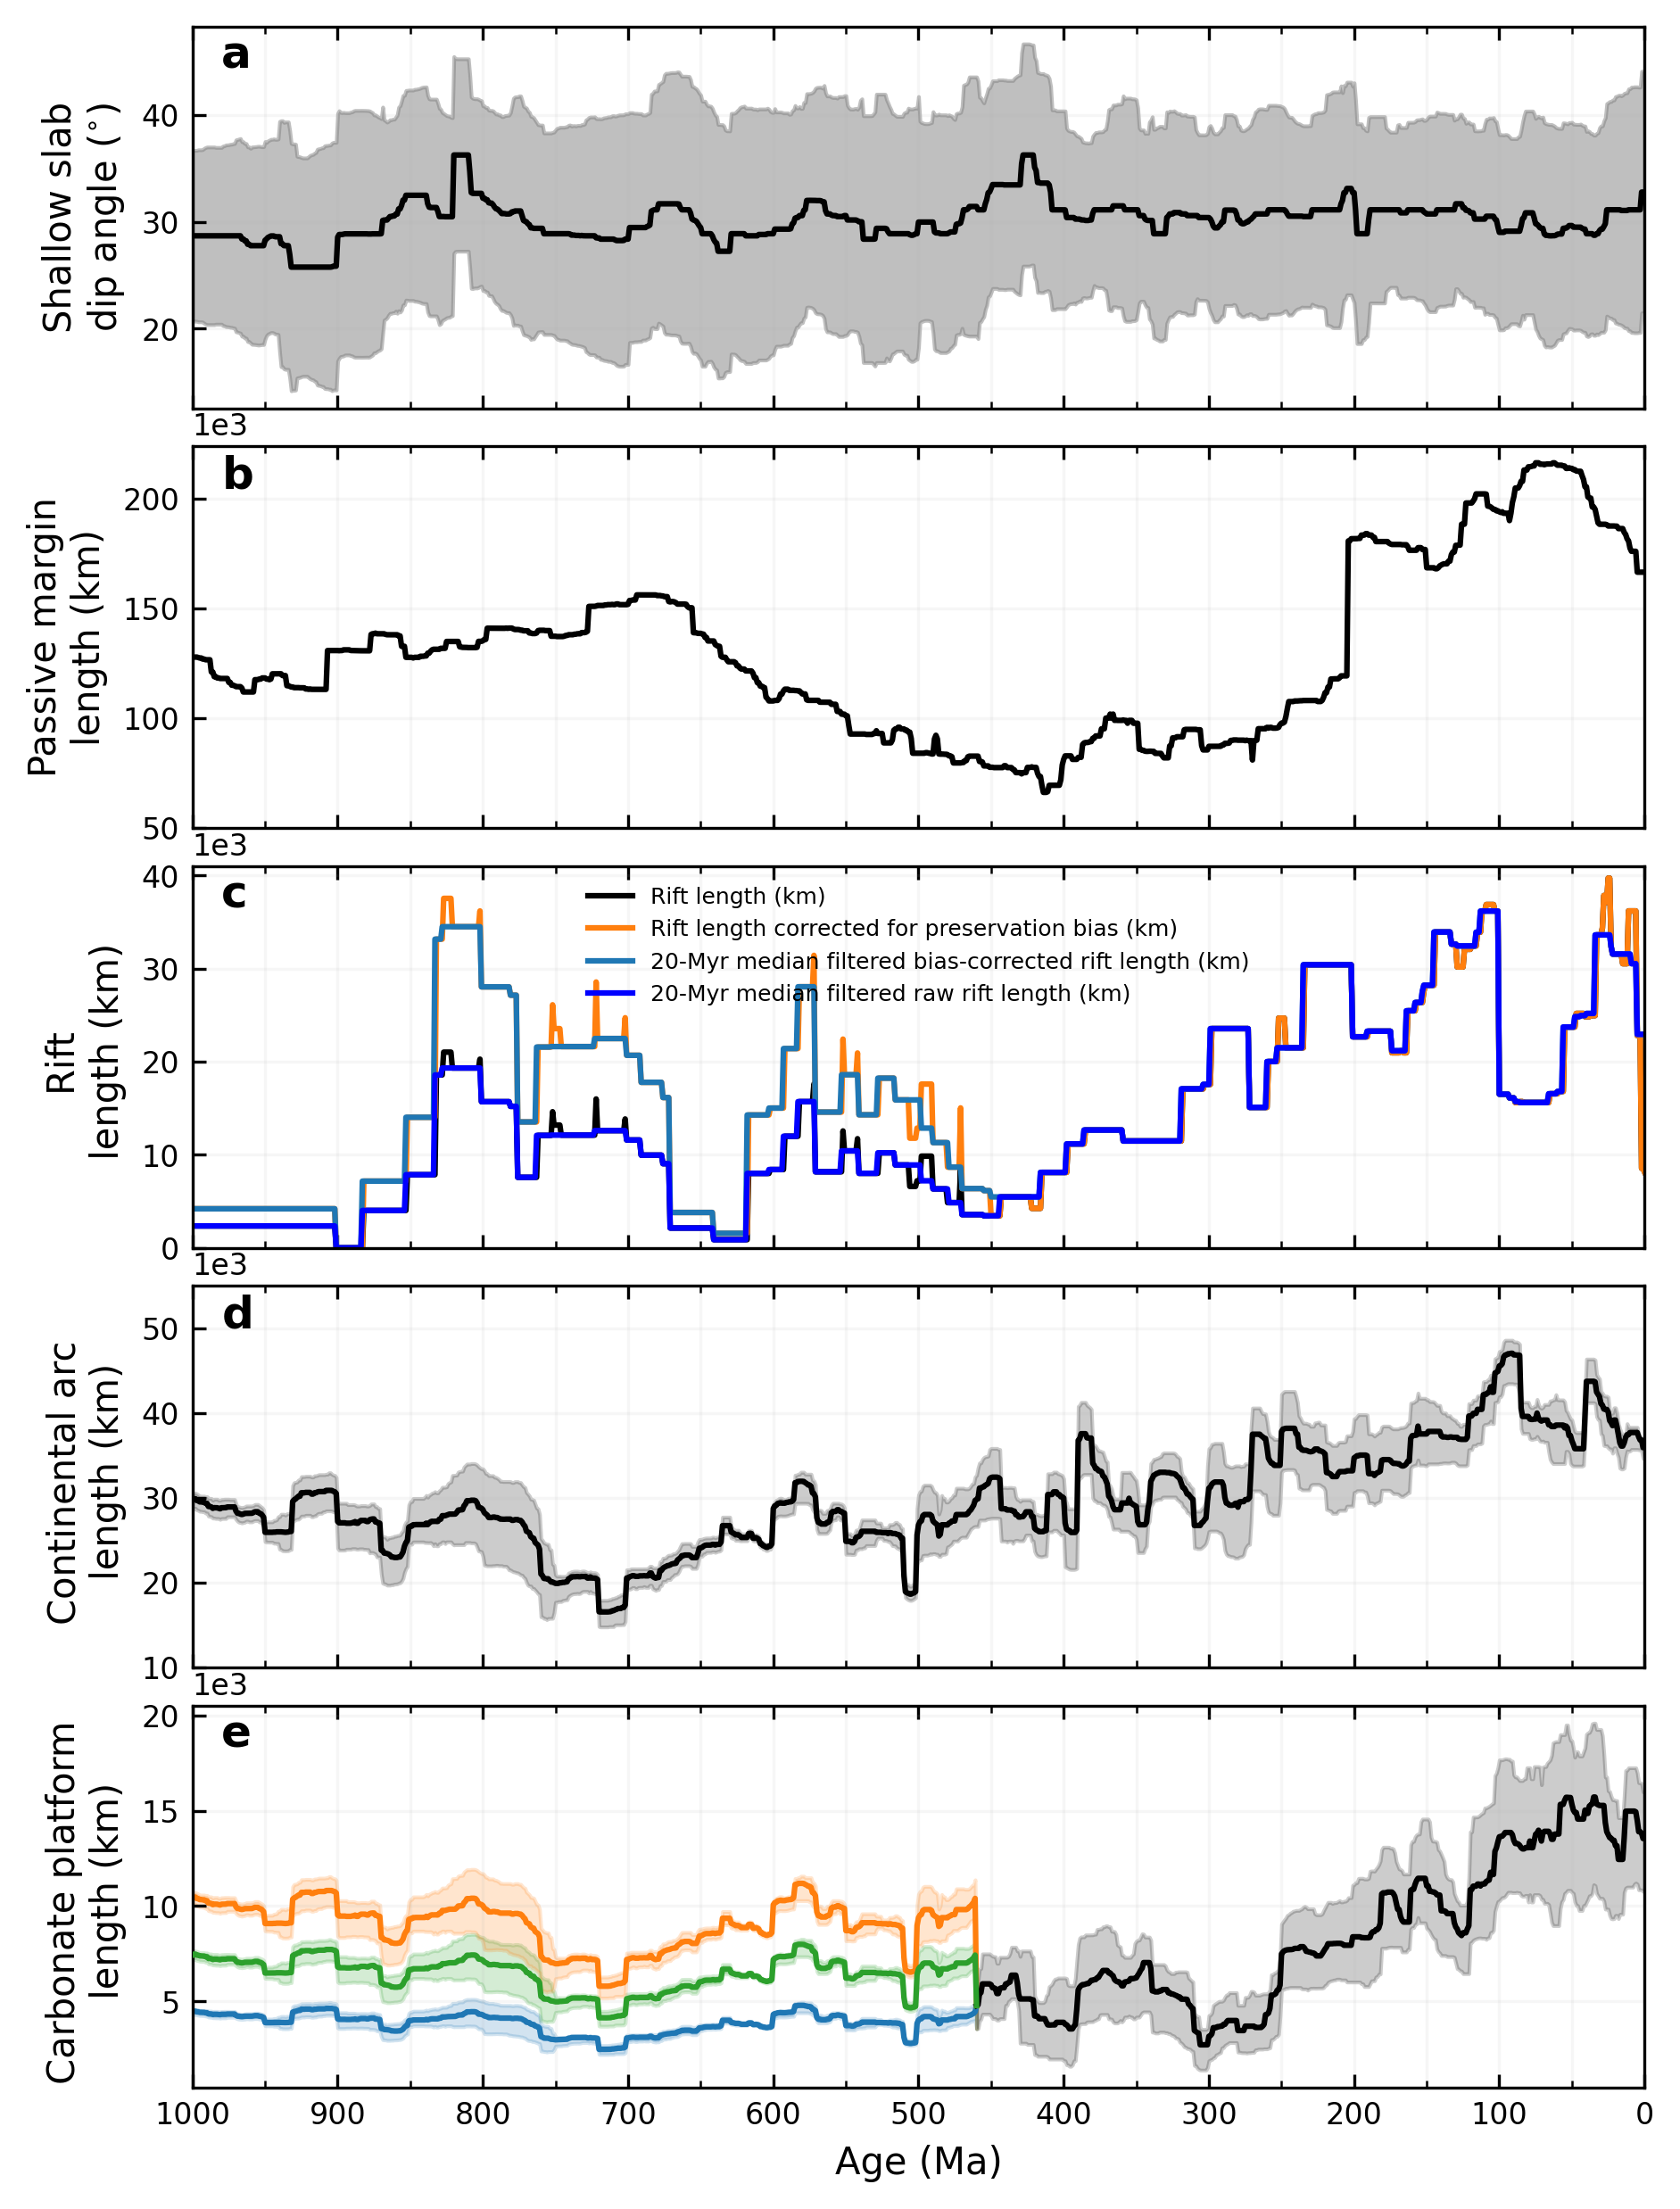

In [26]:
fig, axes = plt.subplots(5, 1, figsize=(7,10), dpi=300)

fig.subplots_adjust(hspace=0.05)
n_axes = len(axes)

for n, ax in enumerate(axes):
    axes[n].tick_params(axis='both', labelsize=8)
    if n>0:
        axes[n].ticklabel_format(style='sci', axis='y', scilimits=(3,3))
        axes[n].yaxis.get_offset_text().set_fontsize(8)
        
axes[0].set_ylabel('Shallow slab\ndip angle ($^{\circ}$)')
axes[0].fill_between(reconstruction_times, slab_dip_mean-slab_dip_std, slab_dip_mean+slab_dip_std,
                     color='0.5', alpha=0.5)
axes[0].plot(reconstruction_times, slab_dip_mean, c='k')

axes[1].set_ylabel('Passive margin\nlength (km)')
axes[1].plot(reconstruction_times, passive_margin_lengths_global, c='k')
axes[1].set_xticks(np.arange(1000,-1,-100),  )
axes[1].set_yticks(np.arange(50000,210001,50000))
#axes[1].set_xticklabels(axes[1].get_xticks(), rotation = 45)
axes[1].ticklabel_format(useOffset=True)


axes[2].set_ylabel('Rift \n length (km)')
ln3 = axes[2].plot(rift_times, 
                   raw_rift_length, c='k', label="Rift length (km)"
)
ln3 = axes[2].plot(rift_times, 
                   multiplier_rift_length, c='C1', label="Rift length corrected for preservation bias (km)"
)
ln3 = axes[2].plot(rift_times, 
                   filtered_multiplier_rift_lengths, c='C0', label="20-Myr median filtered bias-corrected rift length (km)"
)
ln3 = axes[2].plot(rift_times, 
                   filtered_raw_rift_lengths, c='b', label="20-Myr median filtered raw rift length (km)")

axes[2].set_xticks(np.arange(1000,-1,-100),  )
axes[2].set_ylim([0,41000])
axes[2].set_yticks(np.arange(0,41001,10000))
axes[2].legend(loc='upper center', frameon=False, prop={'size': 6})



axes[3].set_ylabel('Continental arc \n length (km)')
ln3 = axes[3].plot(arc_times, 
                   mean_cont_arc_length, c='k', label="Mean dist. tolerance {} km".format(350)
)

axes[3].fill_between(arc_times, min_cont_arc_length, max_cont_arc_length, 
                 color='k', alpha=0.2, label="Uncertainty from min and max dist. tolerances")

axes[3].set_xticks(np.arange(1000,-1,-100),  )
axes[3].set_ylim([10000,55000])
axes[3].set_yticks(np.arange(10000,55001,10000))


colors = ['C0', 'C2', 'C1']
for c in range(0,3):
    
    percentage = percentages[c]
    
    len_pd = pd.read_csv(
        output_directory+"/csv/combined_carbonate_platform_len_{}percent.csv".format(percentage*100),
        index_col=0
    )
    
    headers = ['min_combined_continent_carbonate_platform_length', 
               'mean_combined_continent_carbonate_platform_length',
               'max_combined_continent_carbonate_platform_length' ]
    
    min_scaled_len = np.ravel(len_pd[headers[0]].to_numpy())
    mean_scaled_len = np.ravel(len_pd[headers[1]].to_numpy())
    max_scaled_len = np.ravel(len_pd[headers[2]].to_numpy())

    if c == 1:
        axes[4].plot(
            arc_times[460:], 
            mean_scaled_len[460:],
            color=colors[c], 
            label='Carbonate platform length, percentage {}'.format(percentage*100),
            zorder=4
        )
    else:

        axes[4].plot(
            arc_times[460:], 
            mean_scaled_len[460:],
            color=colors[c], 
            label='Carbonate platform length, percentage {}'.format(percentage*100)
        )
    axes[4].fill_between(
        arc_times[460:], 
        min_scaled_len[460:], 
        max_scaled_len[460:], 
        color=colors[c], alpha=0.2, 
        #label='Uncertainty from 450km and 250km, \n percentage {}km'.format(d_tols[c])
    )
    
# Plot all fluxes from 0-499 in black
axes[4].plot(
    arc_times[:461], 
    mean_scaled_len[:461],
    c='k', 
    label='Carbonate platform length post-460Ma')

axes[4].fill_between(
    arc_times[:461], 
    min_scaled_len[:461], 
    max_scaled_len[:461], 
    color='k', alpha=0.2, 
    #label='Uncertainty from 450km and 250km, \n percentage {}km'.format(d_tols[c])
)


axes[4].set_ylabel('Carbonate platform \n length (km)')
#ln3 = axes[3].plot(reconstruction_times, mean_cont_arc_length, c='k', label="{} km".format(350))
#axes[3].fill_between(reconstruction_times, min_cont_arc_length, max_cont_arc_length,
#                     color='0.5', alpha=0.5)
axes[4].set_xticks(np.arange(1000,-1,-100),  )
#axes[3].set_ylim([10000,50000])
#axes[3].set_yticks(np.arange(10000,50001,10000))
plt.grid(which='both', alpha=0.1)



for i, ax in enumerate(axes):
    ax.set_xlim(max_time, 0)
    ax.set_xticks(np.arange(1000,-1,-100))
    if i < n_axes-1:
        ax.grid(alpha=0.1, which='both')
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.set_xticklabels([])
        ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)
        ax.xaxis.set_minor_locator(MultipleLocator(50))
    else:
        #ax.set_xticklabels(axes[6].get_xticks()[::2], rotation = 45)
        ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)
        ax.xaxis.set_minor_locator(MultipleLocator(50))
        ax.set_xticklabels(axes[n_axes-1].get_xticks())
        ax.set_xlabel("Age (Ma)")
        
        
img_id = ["a","b","c","d","e",]
for i, ax in enumerate(axes):
    
    ax.annotate('{}'.format(img_id[i]), xy=(0.02, 0.98), xycoords='axes fraction', fontsize=12, fontweight="bold",
                horizontalalignment='left', verticalalignment='top')

    
plt.subplots_adjust(hspace=0.1)
plt.show()
fig.savefig(output_directory+"/figures/plate_tectonic_stats_pt2.pdf", dpi=300, bbox_inches='tight')
fig.savefig(output_directory+"/figures/plate_tectonic_stats_pt2.svg", dpi=300, bbox_inches='tight')
fig.savefig(output_directory+"/figures/plate_tectonic_stats_pt2.png", dpi=300, bbox_inches='tight')
